### Compare the scatter of the fitting using different methods

In [37]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.patches as mpatches


def add_label_band(ax, left, right, label, *, spine_pos=-0.12, tip_pos=-0.09, fontsize=15):
    """
    Helper function to add bracket around x-tick labels.

    Parameters
    ----------
    ax : matplotlib.Axes
        The axes to add the bracket to

    top, bottom : floats
        The positions in *data* space to bracket on the y-axis

    label : str
        The label to add to the bracket

    spine_pos, tip_pos : float, optional
        The position in *axes fraction* of the spine and tips of the bracket.
        These will typically be negative

    Returns
    -------
    bracket : matplotlib.patches.PathPatch
        The "bracket" Aritst.  Modify this Artist to change the color etc of
        the bracket from the defaults.

    txt : matplotlib.text.Text
        The label Artist.  Modify this to change the color etc of the label
        from the defaults.

    """
    # grab the yaxis blended transform
    transform = ax.get_xaxis_transform()

    # add the bracket
    bracket = mpatches.PathPatch(
        mpath.Path(
            [
                [left, tip_pos],
                [left, spine_pos],
                [right, spine_pos],
                [right, tip_pos],
            ]
        ),
        transform=transform,
        clip_on=False,
        facecolor="none",
        edgecolor="k",
        linewidth=2,
    )
    ax.add_artist(bracket)

    # add the label
    txt = ax.text(
        (left + right) / 2,
        spine_pos-0.05,
        label,
        ha="center",
        va="center",
        rotation="horizontal",
        clip_on=False,
        transform=transform,
        fontsize=fontsize
    )

    return bracket, txt

Directories of the data file

In [2]:
picDir = '../../pictures/'
dirs = ['2015.1.00271.S', '2016.1.00744.S', '2018.1.01778.S', 'E2E8.1.00003.S', 
        '2018.1.01210.S/X2387', '2018.1.01210.S/X32df', 
        '2018.1.01210.S/X35d1', '2018.1.01210.S/X3e39', 
        '2018.1.01210.S/X4db3', '2018.1.01210.S/X15d7b', 
        '2018.1.01210.S/X1702c', '2018.1.01210.S/X17da2', 
        '2019.1.00013.S/X769c', '2019.1.00013.S/X7b1', 
       '2019.1.00013.S/X1208a']
chans_WVR = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]

Read the fitting information from the data file

In [3]:
fit_errs = []; partfit_errs = []
fit_ranges = []; partfit_ranges = []
for i, dir in enumerate(dirs):
    filename_fit = dir+'/Tsys_WVR_fitted_WVRchan'+str(chans_WVR[i])+'_normScans000.pkl'
    with open(filename_fit,'rb') as pickle_file:
        fit_results = pickle.load(pickle_file, encoding='latin')
    filename_partfit = dir+'/Tsys_WVR_part_fitted_WVRchan'+str(chans_WVR[i])+'_normScans000.pkl'
    with open(filename_partfit,'rb') as pickle_file:
        partfit_results = pickle.load(pickle_file, encoding='latin')
    # read the Tsys spw ids
    spws = list(fit_results.keys())
    spws.remove('info')
    # read the scatter and fitting range of the data
    for spw in spws:
        fit_errs.append(fit_results[spw]['rel_err'])
        fit_ranges.append(fit_results[spw]['Tsys_range'])
        partfit_errs.append(partfit_results[spw]['rel_err'])
        partfit_ranges.append(partfit_results[spw]['Tsys_range'])
        
fit_errs = np.array(fit_errs)
fit_ranges = np.array(fit_ranges)
partfit_errs =  np.array(partfit_errs)
partfit_ranges = np.array(partfit_ranges)

Make the scatter plot of fit error versus the yrange. (Can make a histogram at the right side)

In [4]:
print(np.shape(fit_errs))

(72, 1)


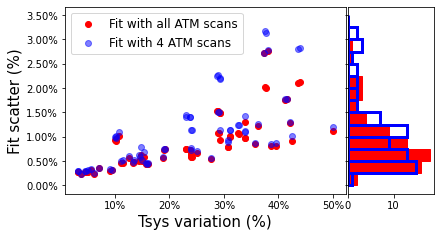

In [5]:
def scatter_yhist(y, ax_histy, **kwargs):
    # no labels
    ax_histy.tick_params(axis="y", labelleft=False)

    # now determine nice limits by hand:
    binwidth = 0.0025
    ymax = np.max(y)
    lim = (int(ymax/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histy.hist(y, bins=bins,orientation='horizontal',**kwargs)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure()
ax = fig.add_axes(rect_scatter)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, 
                                                    symbol='%', 
                                                    is_latex=False))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, 
                                                    symbol='%', 
                                                    is_latex=False))
plt.xlabel('Tsys variation (%)', fontsize=15)
plt.ylabel('Fit scatter (%)', fontsize=15)
plt.scatter(fit_ranges, fit_errs, color='red', label='Fit with all ATM scans')
plt.scatter(partfit_ranges, partfit_errs, color='blue', alpha=0.5, label='Fit with 4 ATM scans')
plt.legend(fontsize=12)

ax_histy = fig.add_axes(rect_histy, sharey=ax)
scatter_yhist(fit_errs, ax_histy, edgecolor='red', facecolor='red')
scatter_yhist(partfit_errs, ax_histy, facecolor='None', edgecolor='blue', linewidth=3)
plt.savefig(picDir+'fit_statistics.pdf', bbox_inches='tight', pad_inches=0.2)

#### Flux comparison among 3 different methods

Read the fluxes from table

In [6]:
filename = '../../logs/flux_comparison.xlsx'
projects = np.array(['2015.1.00271.S', '2016.1.00744.S', '2018.1.01778.S', 'E2E8.1.00003.S', '2018.1.01210.S', '2019.1.00013.S'])
bands = np.array(['Band10', 'Band9a', 'Band8', 'Band7a', 'Band7b', 'Band9b'])
targets = np.array(['Arp 220', 'IRAS16293-B', 'SPT0311-58', 'HT-Lup', 'AS205A', 'Circinus']) 

In [7]:
fluxes = np.full((3,6), fill_value=0.0) 
fluxes_up = np.full((3,6), fill_value=0.0) 
fluxes_low = np.full((3,6), fill_value=0.0)
for i, project in enumerate(projects[:4]):
    flux_table = pd.read_excel(filename, sheet_name=project)
    fluxes[0,i] = flux_table['flux'][0]
    fluxes[1,i] = flux_table['flux'][1]
    fluxes[2,i] = flux_table['flux'][2]
    fluxes_up[0,i] = flux_table['1st flux'][0]
    fluxes_up[1,i] = flux_table['1st flux'][1]
    fluxes_up[2,i] = flux_table['1st flux'][2]
    fluxes_low[0,i] = flux_table['2nd flux'][0]
    fluxes_low[1,i] = flux_table['2nd flux'][1]
    fluxes_low[2,i] = flux_table['2nd flux'][2]
    
fluxes_all = np.stack([fluxes, fluxes_up, fluxes_low],axis=2)
fluxes_mid = np.nanmedian(fluxes_all, axis=2)
Errs_up = np.nanmax(fluxes_all, axis=2) - fluxes_mid
Errs_low = fluxes_mid - np.nanmin(fluxes_all, axis=2)
    
for j, project in enumerate(projects[4:]):
    i = 4 + j
    flux_table = pd.read_excel(filename, sheet_name=project, index_col=0)
    fluxes_mid[0,i] = flux_table['flux_orig']['AVG.']
    fluxes_mid[1,i] = flux_table['flux_extrap']['AVG.']
    fluxes_mid[2,i] = flux_table['flux_partextrap']['AVG.']
    Errs_up[0,i] = flux_table['flux_orig']['STD.']
    Errs_up[1,i] = flux_table['flux_extrap']['STD.']
    Errs_up[2,i] = flux_table['flux_partextrap']['STD.']
    Errs_low[:,4:] = np.copy(Errs_up[:,4:])
    
Errs_rel_up = Errs_up / fluxes_mid
Errs_rel_low = Errs_low / fluxes_mid

Plot the comparison between fluxes

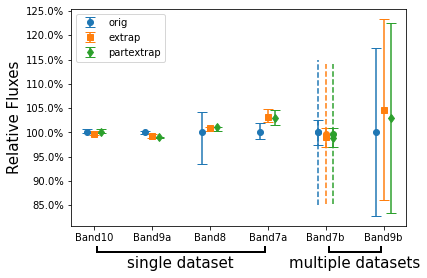

In [52]:
xvals = np.array([1,3,5,7,9,11]); yvals = np.array([1,1,1,1,1,1])
bands_bracket = ['('+band+')' for band in bands]
ticks = map('\n'.join, zip(targets, bands_bracket))

ticks = bands
fig = plt.figure()
ax = plt.subplot(111)

# set the xlabel
# ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
# ax.set_xticklabels('')
# ax.set_xticks([1.5,3.5,5.5,7.5,9.5,11.5], minor=True)
# ax.set_xticklabels(list(projects), minor=True, rotation=60)
ax.set_xticks([1.5,3.5,5.5,7.5,9.5,11.5])
# ax.set_xticklabels(ticks, rotation=60)
ax.set_xticklabels(ticks)
ax.tick_params(which='minor', length=0)
# Format the ticks in yaxis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, 
                                                    symbol='%', 
                                                    is_latex=False))
# set the ylabel
ax.set_ylabel('Relative Fluxes', fontsize=15)

# plot the normalized flux values
plt.errorbar(xvals+0.25, yvals, yerr=np.stack([Errs_rel_up[0], Errs_rel_low[0]],axis=0), marker='o', linestyle='', label='orig', capsize=5)
plt.errorbar(xvals+0.5, fluxes_mid[1]/fluxes_mid[0], yerr=np.stack([Errs_rel_up[1], Errs_rel_low[1]],axis=0), marker='s', linestyle='', label='extrap', capsize=5)
plt.errorbar(xvals+0.75, fluxes_mid[2]/fluxes_mid[0], yerr=np.stack([Errs_rel_up[2], Errs_rel_low[2]],axis=0), marker='d', linestyle='', label='partextrap', capsize=5)
plt.legend(loc='upper left')

# plot the dashed error bars for AS205A
eb=plt.errorbar(9+0.25, 1.0 , yerr = 0.113/0.7549, marker='o', color='tab:blue')
eb[-1][0].set_linestyle('--')
eb=plt.errorbar(9+0.5, 0.7526/0.7549 , yerr = 0.109/0.7549, marker='o', color='tab:orange')
eb[-1][0].set_linestyle('--')
eb=plt.errorbar(9+0.75, 0.7520/0.7549 , yerr = 0.109/0.7549, marker='o', color='tab:green')
eb[-1][0].set_linestyle('--')

# add group labels
add_label_band(ax, 1.6, 7.4, "single dataset")
add_label_band(ax, 9.6, 11.4, "multiple datasets")

# save the figure
plt.savefig(picDir+'flux_comparison.pdf', bbox_inches='tight', pad_inches=0.2)